## Series estacionarios
https://www.statsmodels.org/stable/tsa.html

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

import warnings
warnings.simplefilter("ignore")

Primero vamos a generar una serie estacionaria que servira de ejemplo

In [2]:
np.random.seed(12345)
ar_p = np.array([0.6, -0.2])
ma_p = np.array([0.2])

# Incluyo una constante. Para el caso del AR debo colocarlo en negativo
ar = np.r_[1, -ar_p]
ma = np.r_[1, ma_p]

serie = arma_generate_sample(ar, ma, nsample=100)
serie = pd.Series(serie)

In [3]:
serie[0:10]

0   -0.204708
1    0.315177
2   -0.193602
3   -0.838815
4    1.390066
5    2.788365
6    1.766595
7    0.802612
8    0.953620
9    1.811889
dtype: float64

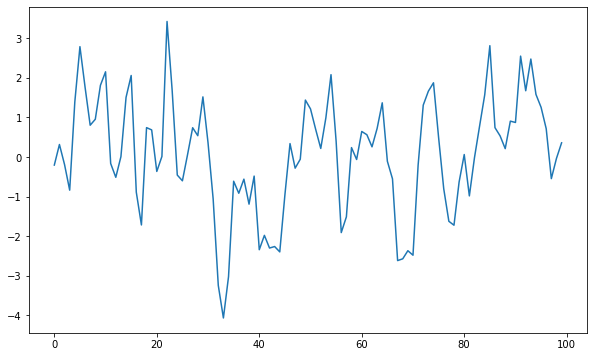

In [4]:
fig = plt.figure(figsize=(10,6))
fig = plt.plot(serie)

plt.savefig("./Graficas/arima_generated.pdf")
plt.show()

Algunas estadísticas de la serie son los siguiente:

In [5]:
print(
f"La media de la series es {np.round(np.mean(serie), 2)}. La desviacion estandar es {np.round(np.std(serie), 2)}"
)

La media de la series es 0.06. La desviacion estandar es 1.46


### Estimaciones
Podemos probar estimando diferentes modelos. Primero con un AR(1)

In [6]:
ar1 = tsa.arima.ARIMA(serie, order=(1,0,0))
ar1 = ar1.fit()

print(ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -149.083
Date:                Mon, 07 Nov 2022   AIC                            304.165
Time:                        00:28:08   BIC                            311.981
Sample:                             0   HQIC                           307.328
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0646      0.330      0.195      0.845      -0.583       0.712
ar.L1          0.6752      0.075      9.050      0.000       0.529       0.821
sigma2         1.1476      0.155      7.389      0.0

Luego, el ARMA(2,1)

In [7]:
arma21 = tsa.arima.ARIMA(serie, order=(2,0,1))
arma21 = arma21.fit()

print(arma21.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -144.533
Date:                Mon, 07 Nov 2022   AIC                            299.066
Time:                        00:28:09   BIC                            312.092
Sample:                             0   HQIC                           304.338
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0623      0.267      0.233      0.816      -0.461       0.586
ar.L1          0.6424      0.377      1.705      0.088      -0.096       1.381
ar.L2         -0.1297      0.304     -0.426      0.6

### Box Jenkins: ACF, PACF

Luego, se puede pedir su ACF y su PACF. Gráficamente parece mostrar que el modelo correcto estaría entre un ARMA(2,1) o un ARMA(2,2)

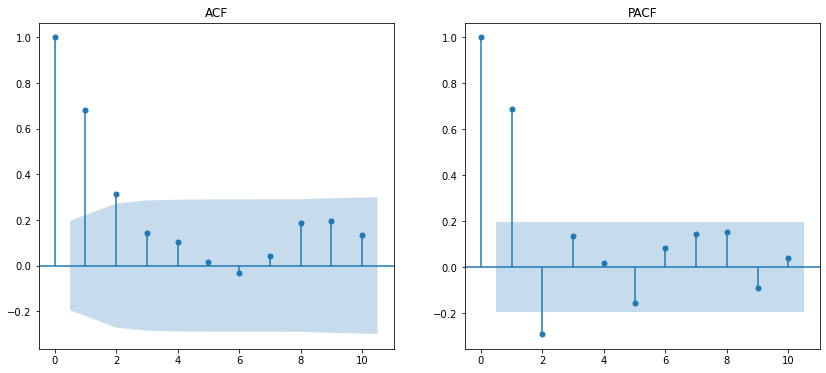

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

plot_acf(serie, ax=ax[0], lags=10, title="ACF", alpha=0.05)
plot_pacf(serie, ax=ax[1], lags=10, title="PACF", alpha=0.05)

plt.savefig("./Graficas/arima_acf_pacf.pdf")
plt.show()

### Selección de un modelo: Criterios de informacion

In [9]:
criterias = arma_order_select_ic(serie, max_ar=3, max_ma=3, ic=["aic", "bic"], trend='nc')

print(f"El mejor modelo seleccionado por AIC es {criterias.aic_min_order} y por BIC es {criterias.bic_min_order}")

El mejor modelo seleccionado por AIC es (0, 2) y por BIC es (0, 2)


Pese a que haya simulado la serie como un ARMA(2,1), los criterios de informacion me seleccionan como el mejor modelo a una MA(2)

In [10]:
model = tsa.arima.ARIMA(serie, order=(0,0,2))
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -144.081
Date:                Mon, 07 Nov 2022   AIC                            296.163
Time:                        00:28:10   BIC                            306.583
Sample:                             0   HQIC                           300.380
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0607      0.235      0.258      0.797      -0.401       0.522
ma.L1          0.8911      0.106      8.373      0.000       0.683       1.100
ma.L2          0.3909      0.093      4.200      0.0

### Analisis de los residuos
Tras la estimacion de un modelo, los residuos deberian comportarse como un ruido blanco. Es decir, no deberia tener autorrelación serial

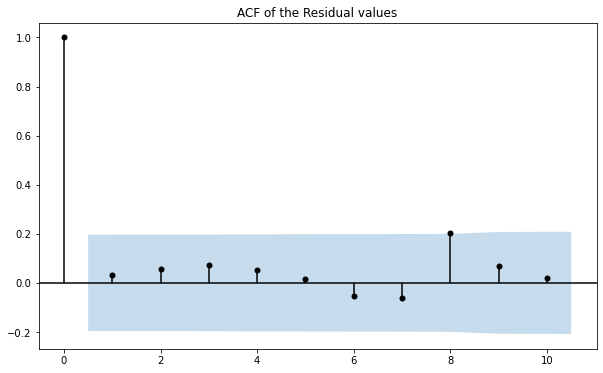

In [11]:
resids = model.resid


fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(resids, ax=ax, lags=10, title="ACF of the Residual values", color="black", vlines_kwargs={"colors": "black"})

plt.savefig("./Graficas/arima_acf_resids.pdf")
plt.show()

Aunque, igual se podría graficar todos los resultados en uno

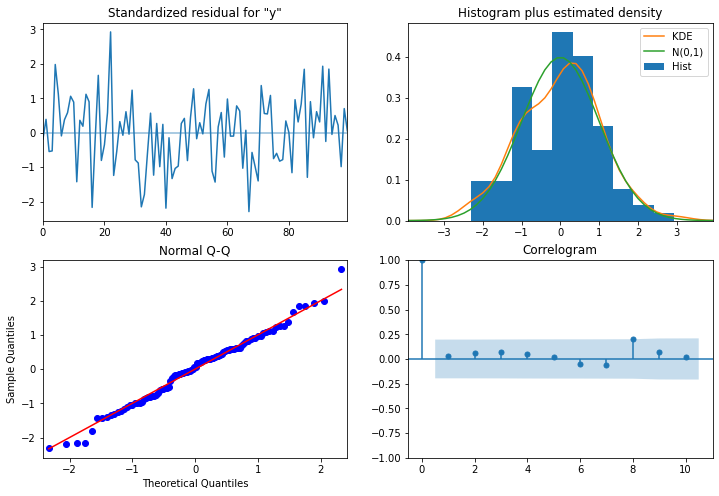

In [12]:
model.plot_diagnostics(figsize=(12,8))

plt.show()

Tambien se podria realizar el test de Durbin-Watson y el de Breush-Pagan

In [13]:
print(
f"El test de Durbin-Watson da como resultado {np.round(durbin_watson(resids), 2)}, por lo que no habria autocorrelacion serial. \
El test de Breusch-Pagan da como p-value a {np.round(acorr_breusch_godfrey(model), 3)[1]}, por lo que no se puede rechazar la hipotesis\
nula de autocorrelacion serial."
) 

El test de Durbin-Watson da como resultado 1.94, por lo que no habria autocorrelacion serial. El test de Breusch-Pagan da como p-value a 0.786, por lo que no se puede rechazar la hipotesisnula de autocorrelacion serial.


### Proyecciones in-sample

Una vez estimado el modelo, se puede graficar ambos juntos

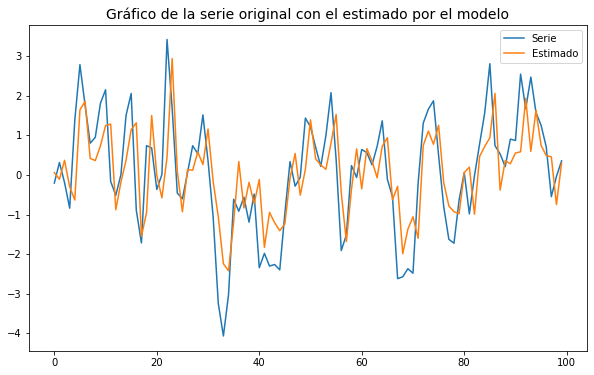

In [14]:
model_est = model.predict()


fig = plt.figure(figsize=(10,6))
fig = plt.plot(serie, label="Serie")
fig = plt.plot(model_est, label="Estimado")

plt.legend()
plt.title("Gráfico de la serie original con el estimado por el modelo", fontsize=14)
plt.savefig("./Graficas/forecast_in_sample.pdf")

plt.show()

### Proyecciones out-sample

In [15]:
# Estimacion
model_f = model.get_forecast(steps=10)

# Proyeciones
model_mean = model_f.predicted_mean
model_ci = model_f.conf_int()

# Generando los DataFrames
fc_series = pd.Series(model_mean)
lower_series = pd.Series(model_ci["lower y"])
upper_series = pd.Series(model_ci["upper y"])

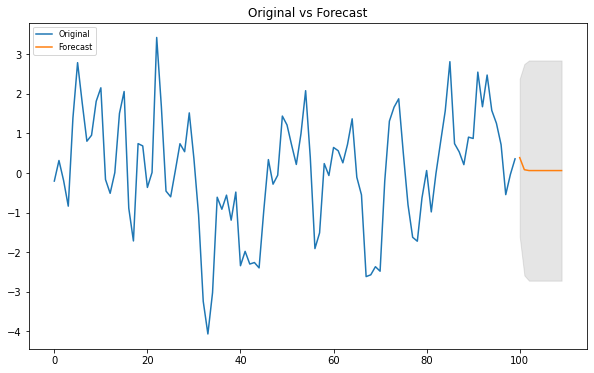

In [16]:
# Plot
plt.figure(figsize=(10,6))

plt.plot(serie, label="Original")
plt.plot(fc_series, label="Forecast")

# Fill
plt.fill_between(lower_series.index, lower_series, upper_series, color="grey", alpha=0.2)

plt.title("Original vs Forecast")
plt.legend(loc="upper left", fontsize=8)

plt.savefig("./Graficas/forecast_out_sample.pdf")
plt.show()